# Algoritmo de reconocimiento de imágenes

Tarea solicitada:
1. Desarrollar una aplicación de reconocimiento de imágenes utilizando técnicas de
aprendizaje automático.
2. La aplicación debe ser capaz de identificar objetos comunes en imágenes
proporcionadas y mostrar el resultado al usuario
3. Utilizar GitHub Copilot para generar parte del código de la aplicación.
4. Implementar un modelo de aprendizaje automático para el reconocimiento de
objetos.
5. Utilizar un conjunto de datos de ejemplo para entrenar y probar el modelo.
6. Desplegar la aplicación en un entorno accesible para su evaluación.

# Desarrollo
Para esta tarea se utiliza un agoritmo de red neuronal convolucional para la detección de patrones en las imagenes ingresadas, tal que estos patrones permitan la identificacion de objetos distintos.
En este caso utilizaré una base de datos de práctica de Kagle, compuesta de los siguientes elementos:
* airplane - 727 imágenes
* car - 968 imágenes
* cat - 885 imágenes
* dog - 702 imágenes
* flower - 843 imágenes
* fruit - 1000 imágenes
* motorbike - 788 imágenes
* person - 986 imágenes

Agrego el enlace para su descarga: https://www.kaggle.com/datasets/prasunroy/natural-images

Es importante conocer la cantidad de imágenes con la que vamos a trabajar, de manera que a aprtir de su distribución se puede elegir hacer un muestreo o realizar un entrenamiento tipo k-fold para compensar clases desiguales. En este caso no se realziará debido a que la dispersión no parece ser un tema importante ya que no hay una desigualdad tan pronunciada, sin embargo este tema se considerará para una posible discusión posterior analizando los resultados.

Lo que si es importante destacar es que el tamaño de las imágenes difiere mucho no solo entre clases sino entre imágenes de cada clase, por lo que es necesario hacer un ajuste de tamaños para asegurar que la entrada del algoritmo que utilizaremos siempre mantenga el mismo tamaño, por lo que la primer sección de este trabajo se dedicará al preprocesado de imágenes y ajustes pertinentes. 

## Carga y organización de los datos
Con este primer fragmento de código estamos observando la estructura de organziación de los datos, siguiendo lo siguiente:

"carpeta1\subcarpeta_n\imagen_n.jpg"

En lo que la carpeta 1 sería "natural_images" y cada subcarpeta sería la perteneciente a las clases descritas anteriormente.

Además, es improtante en este caso concoer de qué carpeta viene cada imagen, ya que con eso podemos crear el conjunto de etiquetas para ayudar al algoritmo a aprender.

In [1]:
#importar librerías
import os #para revisar los directorios con los que trabajaremos

for dirname, _, filenames in os.walk('natural_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

Ahora hay que convertir esas imágenes en arrays que puedan ser procesados para nuestro algoritmo de Deep Learning.

In [2]:
import matplotlib.pyplot as plt #para graficar

img = plt.imread('natural_images/airplane/airplane_0000.jpg')

In [3]:
img.shape #con esto podemos identificar los tamaños de las imágenes

(104, 300, 3)

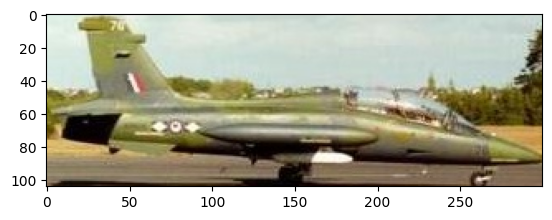

In [4]:
plt.imshow(img)

Ahora estandarizaremos las imágenes a 256*256 pixeles para que todas nuestras imágenes cumplan con la forma de entrada del algoritmo y se puedan procesar sin problemas.

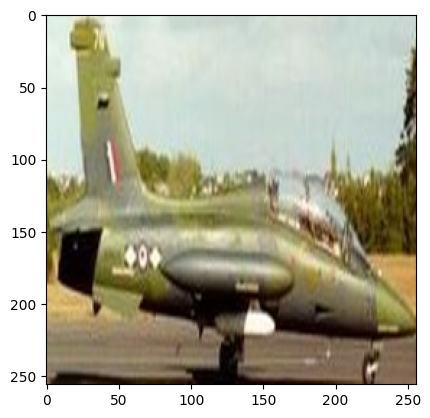

In [5]:
import PIL #para trabajar con imágenes (PYTHON iMAGE lIBRARY)   
from PIL import Image
import numpy as np

#retomamos la imagen del ejemplo anterior
img = Image.open('natural_images/airplane/airplane_0000.jpg')
#y ahora cambiamos el tamaño de la imagen a 256*256 conservando la relación de aspecto en sus 3 canales
img = img.resize((256, 256), Image.LANCZOS)

#convertimos la imagen a un arreglo de numpy
img = np.array(img)

#graficamos la imagen
plt.imshow(img)

Además de esto habrá que normaliazr la imágen para que las intensidades de los colores vayan en una escala de 0 a 1 en vez de 0 a 255.

Este proceso se hará para todas las imágenes del directorio.

In [6]:
from tqdm import tqdm #para hacer barras de progreso

x, y = [], []
#ahora haremos una lista de directorios para axxesar a cada carpeta de imágenes

dirs = ['natural_images/airplane', 'natural_images/car', 'natural_images/cat', 'natural_images/dog', 'natural_images/flower', 'natural_images/fruit', 'natural_images/motorbike', 'natural_images/person']

etiqueta_actual = 0
for d in dirs:
    print(d)
    for dirname, _, filenames in os.walk(d): #para cada directorio en la lista dirs
        for filename in tqdm(filenames): #para cada archivo en el directorio
            img = Image.open(os.path.join(dirname, filename)) #abrimos la imagen
            img = img.resize((256, 256), Image.LANCZOS) #cambiamos el tamaño de la imagen
            img = np.array(img) #convertimos la imagen a un arreglo de numpy
            x.append(img/255) #agregamos la imagen a la lista x y la normalizamos
            y.append(etiqueta_actual) #agregamos la etiqueta a la lista y
    etiqueta_actual += 1 #aumentamos la etiqueta para la siguiente carpeta



natural_images/airplane


100%|██████████| 727/727 [00:00<00:00, 789.93it/s]


natural_images/car


100%|██████████| 968/968 [00:01<00:00, 824.21it/s]


natural_images/cat


100%|██████████| 885/885 [00:01<00:00, 464.62it/s]


natural_images/dog


100%|██████████| 702/702 [00:01<00:00, 462.77it/s]


natural_images/flower


100%|██████████| 843/843 [00:02<00:00, 348.84it/s]


natural_images/fruit


100%|██████████| 1000/1000 [00:01<00:00, 861.13it/s]


natural_images/motorbike


100%|██████████| 788/788 [00:01<00:00, 780.02it/s]


natural_images/person


100%|██████████| 986/986 [00:00<00:00, 1458.14it/s]


Ahora que hemos procesado nuestras imagenes debemos procesar las etiquetas. El algoritmo que usaremos nos devolverá valores probabilísticos de pertenencia a cada clase, por lo que es neesario convertir las etiquetas (valores continuos) a vectores de posición (calores categóricos), más o menos así:

Airplane - etiqueta 0 - vector [1,0,0,0,0,0,0,0]

Donde el 1 se coloca en la posición indice del vector generado, teniendo 8 posiciones posibles para cada las imágenes, dadas cada una de las clases.

In [7]:
from keras.utils import to_categorical #para convertir las etiquetas a one-hot encoding
x, y = np.array(x), to_categorical(np.array(y))

#imprimimos las dimensiones de x y y
print(x.shape, y.shape)


(6899, 256, 256, 3) (6899, 8)


Y podemos ver 6899 imágenes, de tamaño 256*256 pixeles en sus 3 canales de  color (RGB) y 6899 etiquetas en un vector de 8 dimensiones.

Ahora hay que dividir el conjunto de datos en entrenamiento y testing para entrenar el algoritmo y evaluarlo.

El conjunto de datos de training es a partir del cual el modelo aprende las características del conjunto de datos, se ingresa una imagen del conjunto de entrenamiento al modelo, y el modelo la procesa con las herramientas dadas (parte del diseño del algoritmo que explicaré más adelante) para clasificar la imagen, por ejemplo categorizar una imagen y etiquetarla como "avion", para después comparar su resultado con la respuesta real y entonces aprender.

Este proceso continúa con cada imagen ingresada, y compara las características comunes de aquellos datos etiquetados bajo la misma clase y analiza aquellas características comunes para cada clase, ajusta el nivel de importancia de características detectadas y así refina su procesamiento.

Posterior a esto, durante el testing, se realzia otra ronda donde se le dan imágenes al algoritmo sin decirle qué son (la clase) hasta que termina, de manera que podemos ver qué tan bien aprendió durante la fase de entrenamiento.

In [8]:
from sklearn.model_selection import train_test_split #para dividir los datos en entrenamiento y testing

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35) #dividimos los datos en 65% entrenamiento y 35% testing


Ahora corroboramos el tamaño de cada clase para asegurarnos que la distribuición se mantuvo y que la forma de lasimagens no se modificó

In [9]:
shapes = {'X_train': X_train.shape, 'X_test': X_test.shape, 'y_train': y_train.shape, 'y_test': y_test.shape}

for key in shapes:
    print(key, shapes[key]) #imprimimos las dimensiones de los datos de entrenamiento y testing

X_train (4484, 256, 256, 3)
X_test (2415, 256, 256, 3)
y_train (4484, 8)
y_test (2415, 8)


Y podemos observar que el conjunto de datos de training X y Y se mantienen con la misma cantidad de datos (imágenes y sus respectivas etiquetas), lo mismo para el conjunto de datos de testing.

## Modelo de Deep Learning

Para este modelo utilizaremos el algoritmo de convolución. Los algoritmos de convolución son aquellos que utilizan filtros para procesar las imágenes, por ejemplo para resaltar formas, figuras identificables, texturas, intensidad de colores, etc., con lo que le pediremos a GitHub Copilot que cree un algoritmo para trabajar este conjunto de datos y realizaremos los ajustes pertinentes al algoritmo creado.

* Solicitud:
"can you create a CNN algorithm for image recognition of 8 class of images of size (256, 256, 3)?"

* Respuesta:

In [10]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape=(256, 256, 3), num_classes=8):
    model = models.Sequential([
        # Convolutional layer 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        # Convolutional layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Convolutional layer 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Convolutional layer 4
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Flattening the 3D output to 1D
        layers.Flatten(),
        # Dense layer
        layers.Dense(512, activation='relu'),
        # Output layer with softmax activation for multi-class classification
        layers.Dense(num_classes, activation='softmax')
    ])
    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
# Create the CNN model
model = create_cnn_model()
# Model summary
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)     

Ahora expliquemos un poco más a profundidad el algoritmo creado por GitHub. Cada seción descrita como "layer" es una capa de procesamiento, y cada capa es descrita a continuación:
- **Conv2D**: es una capa de procesado convolucional de matrices de 2 dimensiones. Estas capas en la imagen a procesar, y la convolucionan por medio de un filtro ("kernel", que es una matriz que puede tener distintos tamaños) , en este caso es de 3*3. Con este proceso se obtienen un mapa de caraterísticas como bordes, texturas, formas, etc. Estas apas toman como parámetros el número de filtros, el tamaño de los filtros, la función de activación, y el tamaño de entrada (solo para la primer capa).
    - La función de actuvación usada es "relu" (Rectified Linear Unit), que ingresa una serie de valores numéricos no lineales y los rectifica, acercándolos a la linealidad, eprmitiendo que el modelo sea capaza de identificar patrones más complejos.
- **MaxPooling2D**: Es una capa de procesamiento que reduce el tamaño de la imagen (ancho y alto) para ser procesada después con una menor dimensionalidad. Esta capa suele añadirse a procesos relacionados con matrices bidimensionales para reducir elc oste computacional de preocesado, además de controlar hasta cierto punto el overfitting (sobre-entrenamiento, que representa que el modelo memoriza las imágenes en vez de aprender verdaderamente la información que contiene. Esto genera aparentemente buenos resultados en training pero no genera buneos resultados en testing y dificulta su aplicación posterior), además ayuda a que el algoritmo detecte patrones sin importar el tamaño o la orientación de la imagen.
- **Flatten**: Estas capas modifican el ajuste de las neuronas de la red, para convertir todas las neuronas en vectores lineales que se puedan conectar completamente.
- **Dense**: Esta es una capa completamente conectada, normalmente aparee cuando es neecsario omenzar la clasificación de las características aprendidas en cada capa de procesamiento, pero cuando está posicionada específicamente al final, incluye una función de activación que permite al algoritmo hacer un resumend e las característias de acda imagen procesada para devolver un vector de probabilidades de pertenencia a cada clase.
    - Función de activación: 'Softmax' es una función que permite valores de -1 a 1, usada como generador de un vector probabilístico de clasificación, comúnmente aplicada a problemas multiclase.

E Indagando un poco más sobre el modelo tenemos la compilación. La compilación de un algoritmo es básicamente las funciones matemáticas con las que el algoritmo realizará el entrenamiento, es decir, aquello con loq ue el modelo evaluará qué tan bien lo está haciendo al procesar imágenes y clasificarlas. Para los parámetros de compilación tenemos lo siguiente:
- Optimizador: Es un algoritmo que ayuda a la red neuronal a ajustar sus pesos, es decir, determinar cuáles características son importantes y cuáles no lo son, reduciendo los errores. Los optimizadores pueden ajustar distintos atrobutos de la red. En este caso s eutiliza la función 'adam', que es una opción muy popular que combina atributos de las funciones AdaGrad y RMSProp, con lo que se puede llegar a mínimos errores y mejorar aquellas virtudes que consideramos importantes (como precisión, exactitud, especificidad, sensibilidad...).
- Función de costo (Loss): determina el desempeño del modelo, y la forma de evaluar esto depende de la función escogida. Cuando tenemos un problema de multiples clases (como ene ste caso tenemos 8) se suelen usar alguna de las siguientes dos opciones:
    - sparce_categorical_crossentropy: Se utilzia cuando hay 2 o más clases para trabajar, y en este aso el vector de salida se consideran enteros, como etiquetas de datos continuas.
    - categorical_crossentropy: Es el algoritmo utilziado en este modelo, es más eficiente que el anterior, ya que previene problemas de uso de memoria por arreglos grandes.
- Métricas: De esta forma se evalúa al modelo, aunque es similar a la función Loss, estos resultados no los usa el modelo para ajustarse, son más para nuestro conocimiento, y a partir de ello usar nuestro criterio para realizar ajustes a la red neuronal. En este caso se utiliza "accuracy", que es una métrica de Exactitud, donde evaluamos cuántas veces el algoritmo clasificó correctamente una imagen, dividido entre el número de imágenes a clasificar. Existen otras métricas para evaluar algoritmos de inteligencia artificial, pero mas adelante haremos una matriz de confusión donde explicaremos detalles de los resultados obtenidos del desempeño de la red neuronal.


In [11]:
#Ahora si a entrenar el modelo
history = model.fit(X_train, y_train, epochs=15, validation_split=0.1) #entrenamos el modelo con 10 epochs y 10% de validación

Epoch 1/15


127/127 [==============================] - 60s 460ms/step - loss: 0.8765 - accuracy: 0.6810 - val_loss: 0.3799 - val_accuracy: 0.8753
Epoch 2/15
127/127 [==============================] - 59s 464ms/step - loss: 0.3278 - accuracy: 0.8763 - val_loss: 0.3888 - val_accuracy: 0.8686
Epoch 3/15
127/127 [==============================] - 59s 465ms/step - loss: 0.2635 - accuracy: 0.8996 - val_loss: 0.2858 - val_accuracy: 0.9065
Epoch 4/15
127/127 [==============================] - 58s 460ms/step - loss: 0.1366 - accuracy: 0.9455 - val_loss: 0.3046 - val_accuracy: 0.9131
Epoch 5/15
127/127 [==============================] - 58s 455ms/step - loss: 0.0950 - accuracy: 0.9618 - val_loss: 0.3281 - val_accuracy: 0.9087
Epoch 6/15
127/127 [==============================] - 58s 454ms/step - loss: 0.0543 - accuracy: 0.9797 - val_loss: 0.2615 - val_accuracy: 0.9265
Epoch 7/15
127/127 [==============================] - 58s 459ms/step - loss: 0.0840 - accuracy: 0.9742 - val_loss: 0.4082 - val_

Ahora, en este caso usamos un validation split, en el que dividimos los lotes de entrenamiento para generar pequeñas secciones de evaluación, similar al testing, para ayudar al modelo en cada ciclo de entrenamiento (epoch) a conoer sus propio desempeño antes de empezar el siguiente ciclo.


A continuación mostraremos las gráficas de desempeño del algoritmo en su entrenamiento, comparando el desempeño durante entrenamiento y validación por ciclo.

In [12]:
history.history.keys() #imprimimos las métricas que se guardaron durante el entrenamiento

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

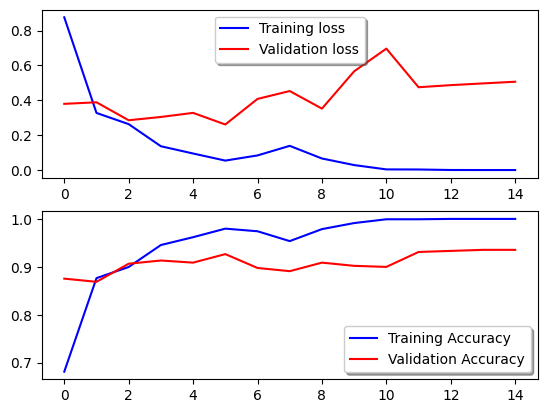

In [13]:
# Graficacion de desempeño durante entrenamiento
#graficos de loss y accuracy
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label='Training loss')
ax[0].plot(history.history['val_loss'], color='r', label='Validation loss')
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label= 'Training Accuracy')
ax[1].plot(history.history['val_accuracy'], color='r', label= 'Validation Accuracy')
legend = ax[1].legend(loc='best', shadow=True)

## Después de entrenar
Típicamente deberíamos empezar la fase de testing ahora y hablar de los reusltados finales, sin embargo en las gráficas de desempeño vemos que el algoritmo es relativamente bueno durante la fase de entrenamiento, sin embargo en la validación no resultó tan bien, loq ue indica precisamente overfitting, por lo que se realizará un proceso llamado "Data Augmentation" en el que se realziarán cambios a las imágenes para darle información "diferente" al modelo para aprender. 

Lo primero que haremos será generar "nuevas imágenes" con las que vamos a pasar las imágenes que ya teníamos por filtros aleatorios para darle imagenes modificadas al algoritmo para entrenar.

In [14]:
from keras.preprocessing.image import ImageDataGenerator #para generar imágenes variadas

data_generator = ImageDataGenerator(
    featurewise_center=False, #sin centrar los datos
    featurewise_std_normalization=False, #sin normalizar los datos
    rotation_range=10, #rotación de 10 grados
    width_shift_range=0.1, #cambio de ancho de 0.1
    height_shift_range=0.1, #cambio de alto de 0.1
    zoom_range=0.2, #zoom de 20%
    horizontal_flip=True) #flip horizontal

Ahora visualicemos un ejemplo de una imagen generada en este proceso.

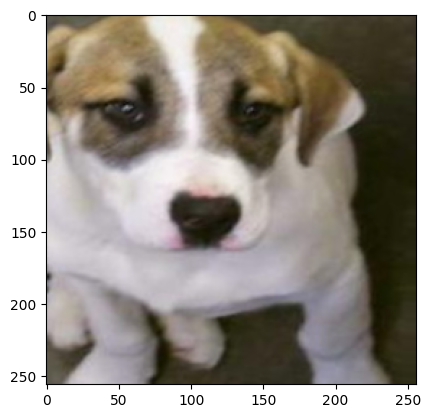

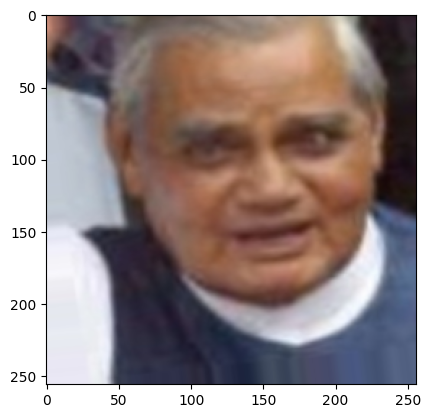

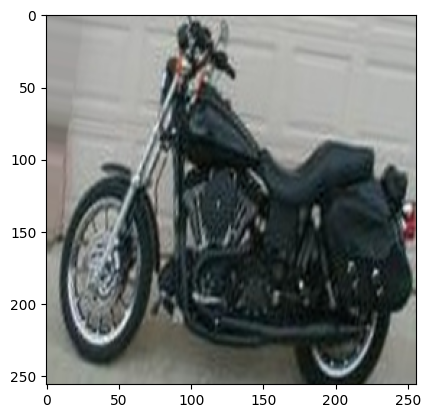

In [15]:
plt.imshow(data_generator.flow(x, y)[0][0][0]) #graficamos una imagen generada
plt.show()
plt.imshow(data_generator.flow(x, y)[0][0][1]) #graficamos una imagen generada
plt.show()
plt.imshow(data_generator.flow(x, y)[0][0][2]) #graficamos una imagen generada
plt.show()

En este punto es necesario realizar un modelo nuevo al que le alimentaremos estos datos y compararemos eld esempeño de ambos modelos. Este modelo nuevo tendrá las mismas características.

In [16]:
model1 = create_cnn_model() #creamos un nuevo modelo

In [17]:
history1 = model1.fit(data_generator.flow(X_train, y_train, batch_size=32), epochs=15) #entrenamos el modelo con 15 epochs

Epoch 1/15
141/141 [==============================] - 79s 557ms/step - loss: 1.1045 - accuracy: 0.5928
Epoch 2/15
141/141 [==============================] - 78s 551ms/step - loss: 0.5285 - accuracy: 0.8008
Epoch 3/15
141/141 [==============================] - 77s 543ms/step - loss: 0.4437 - accuracy: 0.8343
Epoch 4/15
141/141 [==============================] - 74s 525ms/step - loss: 0.3576 - accuracy: 0.8644
Epoch 5/15
141/141 [==============================] - 74s 526ms/step - loss: 0.3270 - accuracy: 0.8760
Epoch 6/15
141/141 [==============================] - 75s 531ms/step - loss: 0.2801 - accuracy: 0.8909
Epoch 7/15
141/141 [==============================] - 77s 547ms/step - loss: 0.2720 - accuracy: 0.9008
Epoch 8/15
141/141 [==============================] - 76s 541ms/step - loss: 0.2360 - accuracy: 0.9072
Epoch 9/15
141/141 [==============================] - 76s 540ms/step - loss: 0.2141 - accuracy: 0.9166
Epoch 10/15
141/141 [==============================] - 76s 540ms/step - l

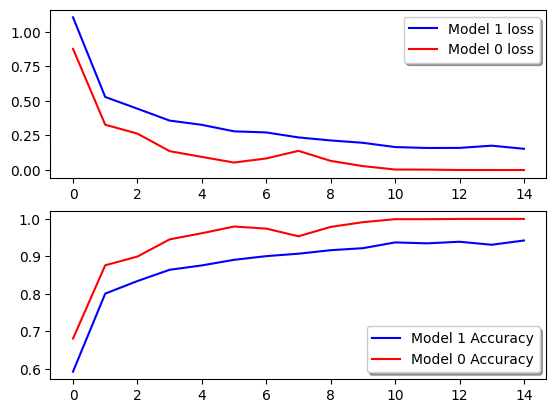

In [18]:
#Graficamos de nuevo para comparar
fig, ax = plt.subplots(2,1)
ax[0].plot(history1.history['loss'], color='b', label='Model 1 loss')
ax[0].plot(history.history['loss'], color='r', label='Model 0 loss')
legend=ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['accuracy'], color='b', label= 'Model 1 Accuracy')
ax[1].plot(history.history['accuracy'], color='r', label= 'Model 0 Accuracy')
legend = ax[1].legend(loc='best', shadow=True)


Ahora, para el modelo nuevo (que es la misma arquitectura pero entrenado on el conjunto de datos modificado) vemos que el modelo original tiene mejor desempeño, pero reordemos que estoe staba dado por el overfitting,a sí que ahora realizaremos el testing para ambos modelos y analizaremos la matriz de confusión resultante para comparar ambos modelos.

In [19]:
model.evaluate(X_test, y_test) #evaluamos el modelo original


76/76 [==============================] - 7s 94ms/step - loss: 0.4718 - accuracy: 0.9284


[0.47180646657943726, 0.9283643960952759]

In [20]:
model1.evaluate(X_test, y_test) #evaluamos el modelo con data augmentation

76/76 [==============================] - 7s 95ms/step - loss: 0.1806 - accuracy: 0.9387


[0.1806241273880005, 0.9387163519859314]

76/76 [==============================] - 7s 97ms/step


Text(0.5, 1.0, 'Confusion Matrix Original Model')

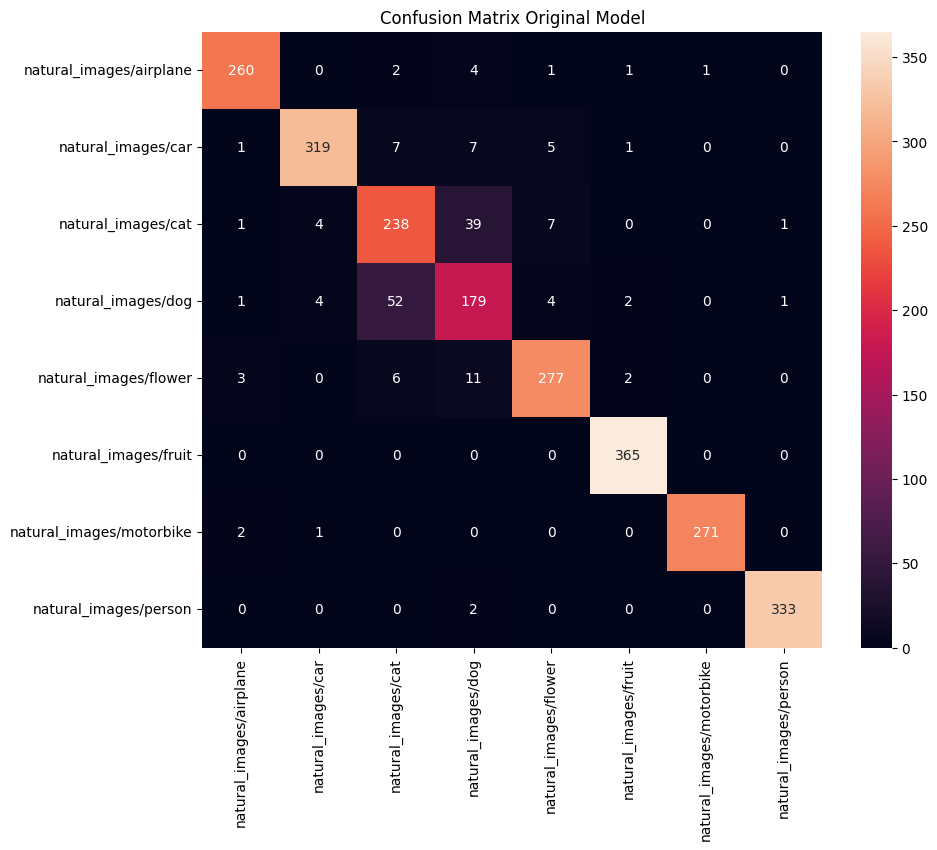

In [21]:
import seaborn as sns #para graficar matrices de confusión
#Matriz de confusion del modelo original
Y_pred0 = model.predict(X_test)
Y_pred0_classes = np.argmax(Y_pred0, axis = 1)
Y_true = np.argmax(y_test, axis=1)

confusion_mtx0 = tf.math.confusion_matrix(Y_true, Y_pred0_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx0, xticklabels=dirs, yticklabels=dirs, annot=True, fmt='g')
plt.title('Confusion Matrix Original Model')


76/76 [==============================] - 7s 96ms/step


Text(0.5, 1.0, 'Confusion Matrix second Model')

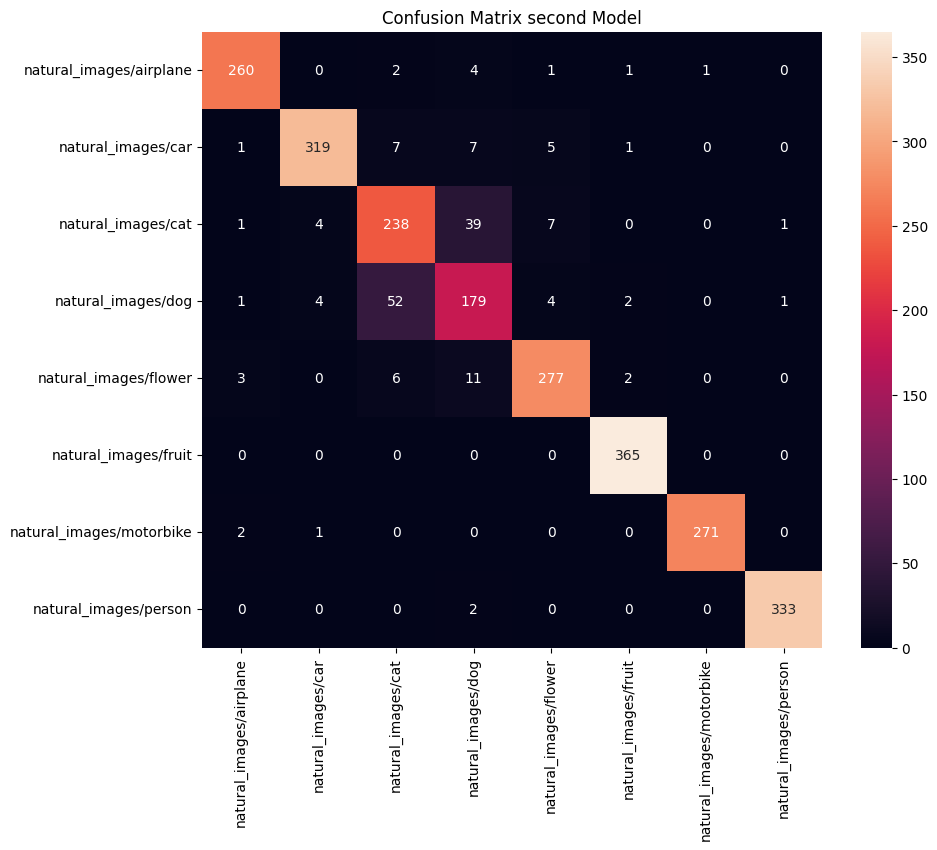

In [22]:
Y_pred0 = model.predict(X_test)
Y_pred1_classes = np.argmax(Y_pred0, axis = 1)
#Y_true = np.argmax(y_test, axis=1)

confusion_mtx1 = tf.math.confusion_matrix(Y_true, Y_pred1_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx1, xticklabels=dirs, yticklabels=dirs, annot=True, fmt='g')
plt.title('Confusion Matrix second Model')

Ahora que hemos visto el comportamiento de ambos modelos, el Loss y Accuracy en la fase de testing demostró ser mejor para el nuevo modelo que para el original, lo que confirma la idea del overfitting que se mostraba anteriormente, y observando al matrzi de confusión podemos observar que las clases más problemátias son las de perro y gato, seguramente por la cantidad de característias en comín entre estos animales. Esto podria ajustarse con una mayor complejidad del algoritmo, ya que no parece haber cambaido muho este problema al ajustar la base de datos, mismo problema para la clase "flower" ya que hubo algunos falsos positivos ahí que podrían representar una falta de especificidad, ya que aunque compartan características como algunas formas o colores, el algoritmo debería de identificar que no son flores.

Además para evitar el overfitting habría agregado algunas capas de dropout en la arquitectura del modelo para prevenir la memorización de las imagenes, o habría realizado un entrenamiento por escalonado (k-fold) para asegurar que el modelo aprenda la suficiente sin memorizar.
Finalmente puedo decir que el factor de la cantidad de imágenes si es importante para estos resultados, ya que en la división de conjuntos de entrenamiento y testing la cantidad de imágenes de cada grupo resultó aún más limitada.

## Cierre de la actividad

Ahora guardaré el segundo modelo, ya que resultó ser el de mejor desempeño, y crearé una aplicación a partir del mismo para su posterior uso.

Este modelo se cargará en un archivo separado para probar su uso con imágenes que se carghara y se normalizarán del mismo modo que las usadas para entrenamiento (antes del data augmentation)

In [23]:
model.save('modelos/model0.h5') #guardamos el modelo
model1.save('modelos/model1.h5') #guardamos el modelo con data augmentation

c:\Users\diana\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


En este código (anexo imágen del código) se evalúa cada imagen en una carpeta de imagenes de prueba on cada modelo, con el fin de analizar el resultado con ambos modelos. Si se desea realizar más pruebas basta con ingresar las imágenes en la carpeta y el algoritmo se encargará de ajustar la imagen y normalizarla para luego procesarla.

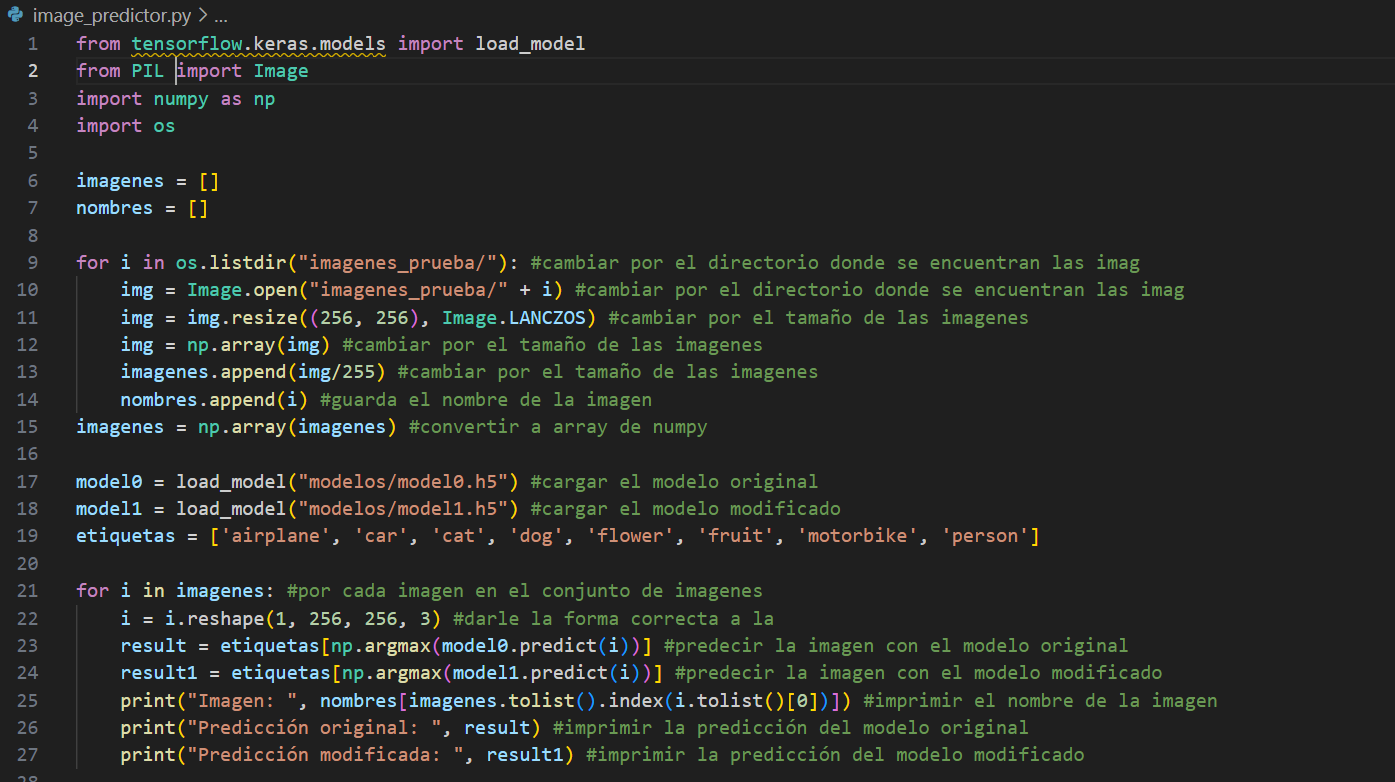


Este código puede ejecutarse desde terminal, solo hay que cuidar la colocación de los archivos:
- imagenes_prueba: es la carpeta donde se deben guardar las imágenes a analizar, en este caso se utilizó el formato jpg.
- modelos: en esta carpeta se guardan los modelos automáticamente y de ahi se cargan para su ejecución.

He realizado una prueba con un conjunto pequeño de imágenes (una imágen por clase) y estos son los resultados obtenidos:

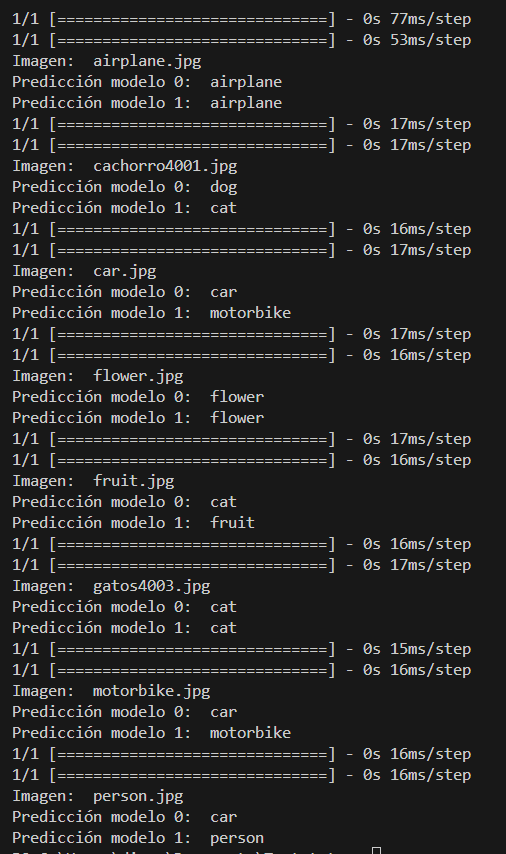

Es evidente que ambos modelos tienen fallos, y se deben de perfeccionar antes de ser utilizados en aplicaciones sensibles, sin embargo este es un buen ejercicio para analizar este tipo de algoritmo y discutir sobre los posibles ajustes que permitan mejorar los resultados.